# Neural style transfer

In [ ]:
import os
import tensorflow as tf
# Tải các mô hình nén từ tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

## Visualize the input

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## TensorFlow Hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

TensorFlow Hub là một kho lưu trữ và thư viện mở để máy học có thể tái sử dụng. Các tfhub.dev kho cung cấp nhiều mô hình pre-train: embeddings văn bản, các mô hình phân loại hình ảnh, TF.js / mô hình TFLite và nhiều hơn nữa. Kho được mở cho người đóng góp cộng đồng .

Các tensorflow_hub thư viện cho phép bạn tải về và tái sử dụng chúng trong chương trình TensorFlow của bạn với một số tiền tối thiểu của mã.

TF2 SavingModels có 2 cách sử dụng: 
- API hub.load() cấp thấp
- Trình bao bọc hub.KerasLayer của nó. (Thông thường, hub.KerasLayer được kết hợp với các tf.keras.layers khác để tạo mô hình Keras hoặc model_fn của Công cụ ước tính TF2.) 

### Ví dụ sử dụng SavingModels từ TF Hub

#### Sử dụng SavingModel trong Keras

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________


Các trọng số của mô hình trong một hub.KerasLayer được đặt thành không thể huấn luyện theo mặc định. Xem phần tinh chỉnh bên dưới để biết cách thay đổi điều đó. Các trọng số được chia sẻ giữa tất cả các ứng dụng của cùng một đối tượng lớp, như thường lệ trong Keras.

#### Sử dụng SavingModel trong TensorFlow cấp thấp

Hàm hub.load(handle) tải xuống và giải nén một SavingModel (trừ khi handle đã là một đường dẫn hệ thống tệp), sau đó trả về kết quả tải nó bằng hàm tích hợp sẵn của TensorFlow tf.saved_model.load() . Do đó, hub.load() có thể xử lý bất kỳ SavingModel hợp lệ nào.

In [ ]:
content_path = tf.keras.utils.get_file('d3305f1a76111419459a883a11202fac.jpg','https://i.ibb.co/dJ6gYSv/d3305f1a76111419459a883a11202fac.jpg')
style_path = tf.keras.utils.get_file('test.jpg','https://i.ibb.co/PmdRzKZ/test.jpg')

12637/12637 [==============================] - 0s 0us/step


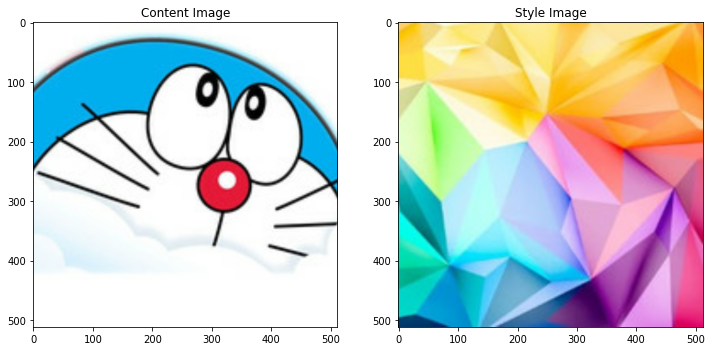

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

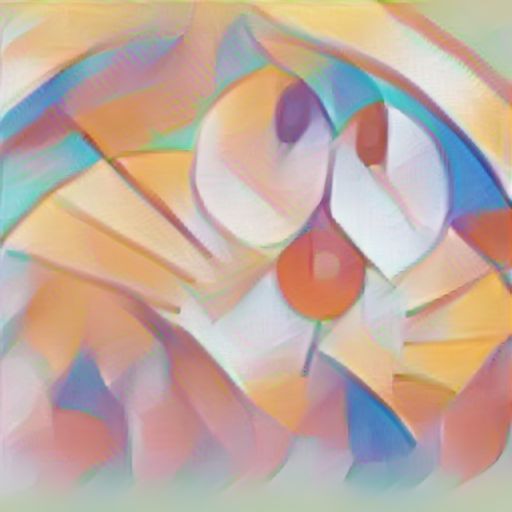

In [ ]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Chi tiết về TF Hub
[saving model trong TF hub](https://www.tensorflow.org/hub/tf2_saved_model?hl=vi)

## VGG 19


VGG-19 model tương tự như mô hình VGG-16. Simonyan và Zisserman giới thiệu mô hình VGG. VGG-19 được đào tạo trên hơn một triệu hình ảnh từ cơ sở dữ liệu ImageNet. Mô hình này có 19 lớp của mạng nơ-ron sâu, có thể phân loại hình ảnh thành 1000 loại đối tượng.

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 25s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('bathing_cap', 0.12601383),
 ('wall_clock', 0.114893034),
 ('hair_slide', 0.109061085),
 ('analog_clock', 0.09140603),
 ('pinwheel', 0.07989572)]

Bây giờ tải `VGG19` không có đầu phân loại và liệt kê tên lớp


In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Ở mức độ cao, để một mạng thực hiện phân loại ảnh (mà mạng này đã được đào tạo để làm) thì nó phải hiểu được ảnh. Điều này đòi hỏi phải lấy hình ảnh thô làm pixel đầu vào và xây dựng một biểu diễn bên trong để chuyển đổi pixel hình ảnh thô thành một sự hiểu biết phức tạp về các đặc điểm có trong hình ảnh.

Đây cũng là lý do tại sao mạng nơ-ron tích tụ có khả năng tổng quát hóa tốt: chúng có thể nắm bắt các bất biến và xác định các tính năng bên trong các lớp (ví dụ: mèo và chó) không có khả năng chống lại tiếng ồn xung quanh và các phiền toái khác. Do đó, ở đâu đó giữa nơi hình ảnh thô được đưa vào mô hình và nhãn phân loại đầu ra, mô hình đóng vai trò như một bộ trích xuất tính năng phức tạp. Bằng cách truy cập các lớp trung gian của mô hình, bạn có thể mô tả nội dung và kiểu dáng của hình ảnh đầu vào.

## xây mô hình


Các mạng trong tf.keras.applications được thiết kế để bạn có thể dễ dàng trích xuất các giá trị lớp trung gian bằng cách sử dụng API chức năng Keras.

Để xác định một mô hình bằng cách sử dụng API chức năng, hãy chỉ định các đầu vào và đầu ra:

model = Model(inputs, outputs)

Hàm sau đây xây dựng mô hình VGG19 trả về danh sách các đầu ra của lớp trung gian:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Và để tạo mô hình:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  828.13403
  mean:  41.587814

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  4081.5005
  mean:  178.87619

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  10163.467
  mean:  144.29839

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  18314.223
  mean:  570.3034

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  2495.1475
  mean:  43.304962



## Calculate style

Nội dung của hình ảnh được thể hiện bằng các giá trị của các bản đồ đối tượng trung gian.

Hóa ra, phong cách của một hình ảnh có thể được mô tả bằng các phương tiện và mối tương quan trên các bản đồ đối tượng địa lý khác nhau. Tính toán ma trận Gram bao gồm thông tin này bằng cách lấy tích ngoài của vectơ đặc trưng với chính nó tại mỗi vị trí và lấy trung bình sản phẩm bên ngoài đó trên tất cả các vị trí. Ma trận Gram này có thể được tính toán cho một lớp cụ thể như sau:


$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Điều này có thể được thực hiện ngắn gọn bằng cách sử dụng hàm tf.linalg.einsum :

### gram matrix

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Xem xét N-vectors $x_1,...., x_m$. Ma trận Gram của tập hợp là m x m ma trận G có các phần tử $G_{ij} = x_i^Tx_j$. Ma trận có thể được biểu diễn gọn dưới dạng ma trận X = $[x_1,....,x_m]$, như
$G = X^TX $
Theo cách xây dựng này ma trận Gram luôn đối xứng $(G_{ij} = G_{ji})$ với mọi cặp (i,j). Nó cũng là bán xác định dương , nghĩa là $u^TGu >= 0$ với mọi vectơ u thuộc $R^n$ (điều này xuất phát từ bản sắc $u^TGu = |Xu|_2^2)$.

Gram Matrix phát sinh từ một hàm trong không gian hữu hạn chiều; khi đó các mục nhập của Gram Matrix là sản phẩm bên trong của các dịch vụ thiết yếu của không gian con hữu hạn chiều. Chúng tôi phải tính toán sự style loss. Nhưng chúng tôi chưa được chỉ ra “tại sao sự style loss được tính bằng Gram Matrix.” Gram Matrix nắm bắt “sự phân bố của các đối tượng địa lý” của một tập hợp các bản đồ đối tượng địa lý trong một lớp nhất định.

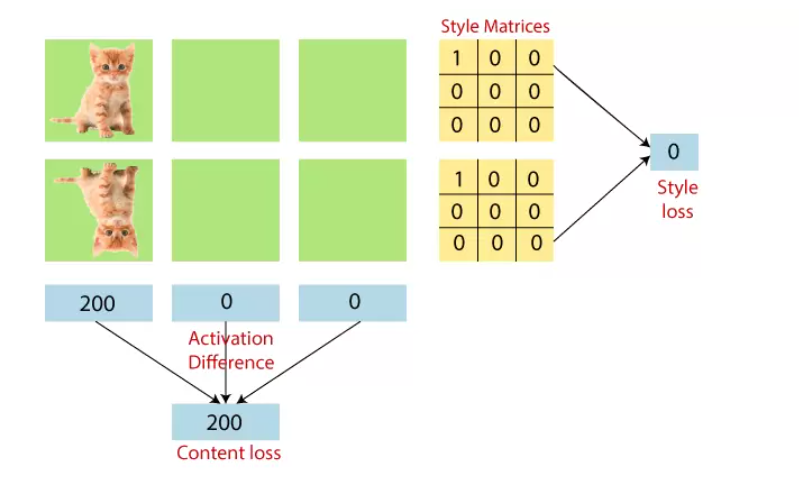

#### Final loss

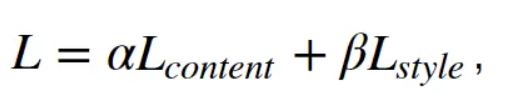

Trong đó α và β là các siêu tham số do người dùng xác định. Ở đây β đã hấp thụ hệ số chuẩn hóa M ^ l được xác định trước đó. Bằng cách kiểm soát α và β, chúng ta có thể kiểm soát lượng nội dung và phong cách được đưa vào hình ảnh được tạo. Chúng ta cũng có thể thấy một hình dung đẹp mắt về các tác động khác nhau của các giá trị α và β khác nhau trong bài báo.

Quá trình Style Transferring
Neural style transfer là một kỹ thuật tối ưu hóa được sử dụng cho hai hình ảnh – hình ảnh nội dung và hình ảnh tham chiếu kiểu – và chúng được hợp nhất để hình ảnh đầu ra trông giống như hình ảnh nội dung nhưng theo kiểu của hình ảnh tham chiếu kiểu “được mô tả” Là.

Để đạt được sự Neural style transfer, cần phải tách style của hình ảnh khỏi nội dung của nó. Sau đó, có thể chuyển các yếu tố phong cách của một ảnh sang các yếu tố nội dung của ảnh khác. Quá trình này chủ yếu được thực hiện bằng cách sử dụng dạng trích xuất đặc trưng của mạng nơ ron phi tuyến tiêu chuẩn.

Các tính năng này sau đó được thao tác để trích xuất thông tin nội dung hoặc thông tin phong cách. Quá trình này bao gồm ba hình ảnh, một hình ảnh phong cách, một hình ảnh nội dung và cuối cùng, một hình ảnh đích.

Mục đích cuối cùng là phong cách của hình ảnh phong cách kết hợp với nội dung của hình ảnh nội dung để tạo ra hình ảnh.


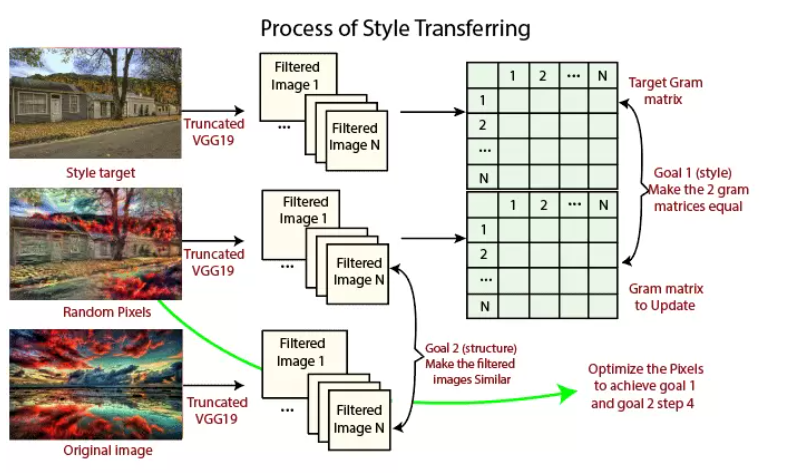

Quá trình này bắt đầu bằng cách chọn một số lớp từ bên trong mô hình của chúng tôi để trích xuất các tính năng. Chúng tôi có một ý tưởng hay về cách hình ảnh của chúng tôi được xử lý trong mạng nơ-ron bằng cách chọn một vài lớp để trích xuất các tính năng. Chúng tôi xóa các thuộc tính mô hình của hình ảnh phong cách và hình ảnh nội dung của chúng tôi. Sau đó, chúng tôi xóa các phần tử khỏi hình ảnh mục tiêu của mình và so sánh nó với tính năng hình ảnh phong cách và tính năng hình ảnh nội dung của chúng tôi.

### High-level architecture

Neural style transfer sử dụng mạng nơ-ron tích chập liên tục. Sau đó, xác định một hàm mất mát kết hợp hoàn toàn hai hình ảnh để tạo ra tác phẩm nghệ thuật hấp dẫn trực quan, NST xác định các đầu vào sau:

Một hình ảnh nội dung (c) – Hình ảnh chúng tôi muốn chuyển kiểu sang
(Các) hình ảnh tạo kiểu – Hình ảnh mà chúng tôi muốn di chuyển phương thức từ
Hình ảnh đầu vào (g) – Hình ảnh chứa kết quả cuối cùng.
Kiến trúc của mô hình giống nhau, cũng như sự mất mát, được tính toán, được hiển thị bên dưới.

### Loss functions

Trong phần này, chúng tôi xác định hai hàm mất mát; chức năng mất kiểu dáng và chức năng nội dung. Chức năng mất nội dung đảm bảo rằng sự kích hoạt của lớp cao hơn là tương tự giữa hình ảnh được tạo ra và hình ảnh nội dung.

## Extract style and content

## gradient descent

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

### Content cost function

Hàm chi phí nội dung chắc chắn rằng nội dung hiện diện trong hình ảnh nội dung được thu vào hình ảnh được tạo. Người ta thấy rằng CNN nắm bắt thông tin về nội dung ở các cấp cao hơn, trong đó các cấp thấp hơn tập trung nhiều hơn vào các giá trị pixel đơn.

Gọi $A ^ l_ {ij}$ (I) là kích hoạt của lớp thứ l, bản đồ đối tượng thứ i và vị trí thứ j đạt được bằng cách sử dụng hình ảnh I. Khi đó, mất mát nội dung được định nghĩa là
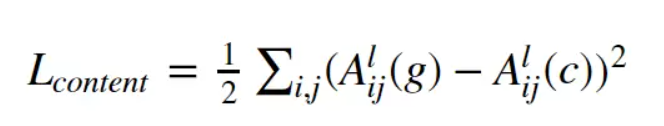


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00017569844
    max:  156530.4
    mean:  1033.9546

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  271656.53
    mean:  21721.2

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  435726.3
    mean:  21357.191

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4251441.0
    mean:  253271.81

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  129191.6
    mean:  1737.0785

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1735.6106
    mean:  12.485326


### Style Loss function

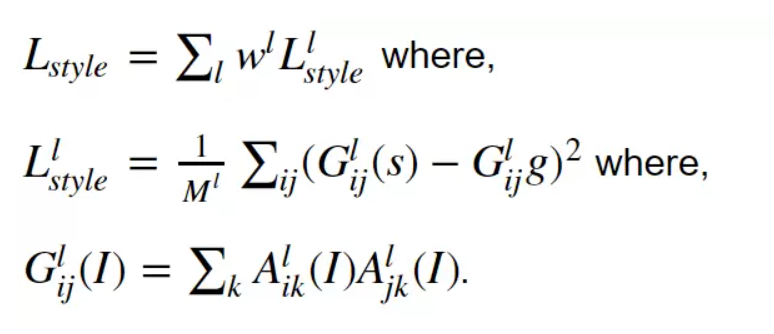

Mục tiêu chính là tính toán ma trận kiểu cho hình ảnh gốc và hình ảnh kiểu.

Sau đó, mất kiểu được định nghĩa là hiệu số bình phương căn bậc hai giữa hai ma trận kiểu.
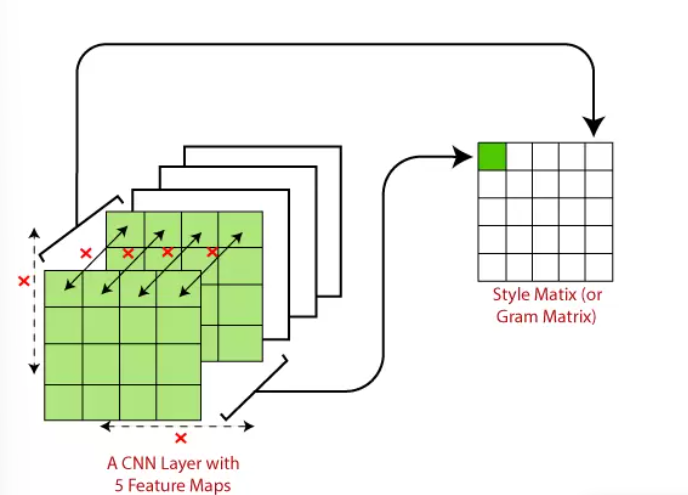

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

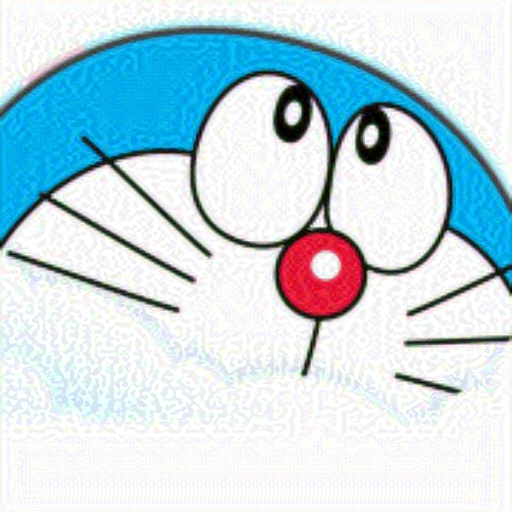

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

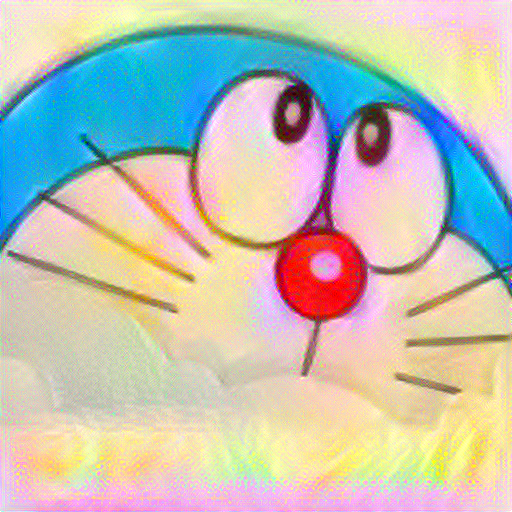

Train step: 600
...................................................................................

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
total_variation_loss(image).numpy()

In [ ]:
tf.image.total_variation(image).numpy()